In [164]:
!conda install anaconda::kagglehub --yes

Channels:
 - conda-forge
 - nvidia
 - pytorch
 - anaconda
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [165]:
import kagglehub


path = kagglehub.dataset_download("vasylhunia/testdataset")

print("Path to dataset files:", path)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1


In [166]:
#Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1

In [167]:
#!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

In [168]:
DATA_PATH = '/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/'

In [169]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [170]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [171]:
torch.cuda.get_device_name(0)

'NVIDIA A10G'

In [172]:
df = pd.read_csv(DATA_PATH + 'faces_metadata.csv')
df

,file_path,label
0,deepfake-detection/FAKE/FAKE/dfdc_train_part_9...,FAKE
1,deepfake-detection/FAKE/FAKE/dfdc_train_part_4...,FAKE
2,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
3,deepfake-detection/FAKE/FAKE/dfdc_train_part_8...,FAKE
4,deepfake-detection/FAKE/FAKE/dfdc_train_part_7...,FAKE
...,...,...
4455,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4456,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4457,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL
4458,deepfake-detection/REAL/REAL/dfdc_train_part_9...,REAL


In [173]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((DATA_PATH + file_path, row['label']))

    return result


def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  
    cap.release()
    
    return frame_count, fps

In [174]:
video_stats = []
result = process_file_paths(df)

for video_path, label in result:
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label,
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)
#df = df[df['fps'] >= 28]

FPS статистика:
count    4460.000000
mean       28.552242
std         1.689965
min        12.000000
25%        29.000000
50%        29.000000
75%        29.000000
max        30.000000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    4460.0
mean       50.0
std         0.0
min        50.0
25%        50.0
50%        50.0
75%        50.0
max        50.0
Name: frames, dtype: float64


In [175]:
files_to_remove_unique = set(['avjwhrqbwl_0', 'bpqrwvichd_0', 'cctrhqvein_0', 'eupisnxhsb_0', 'gerhijzwvq_0', 'katmliewya_0', 'onoowfeded_0',
                  'pydbvfkslp_0', 'qqisdvvgfi_0', 'sclvdumbkh_0', 'snphlfsrmr_0', 'spxqkpmopb_0', 'vugbaeziku_0', 'vvtcvjvkqx_0',
                   'xuoqfchsfj_0', 'zdkyyawcwe_0', 'mshechsves_0', 'ejwvqbeyef_0', 'pqbyjmgmrk_0', 'drmtykanjz_0', 'fktxniwzxe_0',
                   'iynuflmhau_0', 'kligyzlcuk_0', 'kifzxbsnku_0', 'kifzxbsnku_0', 'euarbrmuzs_0', 'fodhjwybqm_0', 'pbpgyiimwt_0',
                   'qmqfqyqmfx_0', 'thmwcolqan_0', 'xhwacojjdg_0', 'xkwjjjkcam_0', 'zktuaqrqqv_0', 'cioizeilvz_0', 'cotvlcroov_0',
                   'tuxbzsrszr_0', 'ynpqkrmuap_0', 'gomxkjifiu_0', 'ukrckkvaqi_0', 'vlcbaytswm_0', 'wmobvmntzu_0', 'ydqeopjemz_0',
                   'cxfbhgmuyu_0', 'hqqmtxvbjj_0', 'jaetnqgktl_0', 'yurtzoovou_0', 'hlcqjuwpsd_0', 'iarobzzslu_0', 'ailmasxkxb_0',
                   'bbwrqfawrj_0', 'cefzoeryat_0', 'egcuyhyvsm_0', 'eqgipviesf_0', 'fwekcrqdak_0', 'giqncczwue_0', 'hslupphtel_0',
                   'jmqmljznhv_0', 'lkbpavasad_0', 'osqruujwxd_0', 'pjibpowymk_0', 'ptchnzeeqc_0', 'sppyyoqaey_0', 'tohrqjyter_0',
                   'xzcexrifxq_0', 'aahncigwte_0', 'fszexmwczt_0', 'fszexmwczt_0', 'lkgrqfcrps_0', 'cdgrttukjn_0', 'eclxonfxph_0',
                   'eclxonfxph_0', 'gzbagbdubm_0', 'hhhvnhhqsc_0', 'junllgghcq_0', 'qyefejorlb_0'
                  ])
files_to_remove = list(files_to_remove_unique)
#df = df[~df['file_path'].apply(lambda x: any(file in x for file in files_to_remove))]
#df

In [176]:
def df_to_list(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((file_path, row['label']))

    return result


result = df_to_list(df)
result

[('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_9/qudhlvaxtc_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_4/jzxzzmcplq_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/pydbvfkslp_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_8/vytklfqusv_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_7/uqkdiusxtz_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/snphlfsrmr_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/ver

In [177]:
groups = defaultdict(list)
for file_path, label in result:
    base_name = os.path.basename(file_path).split('_')[0]
    groups[base_name].append((file_path, label))

single_element_groups = [group for group in groups.values() if len(group) == 1]

single_element_groups


[[('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_9/qudhlvaxtc_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_4/jzxzzmcplq_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/pydbvfkslp_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_8/vytklfqusv_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_7/uqkdiusxtz_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/snphlfsrmr_0.mp4',
   'FAKE')],
 [('/home/ec2-user/.cache/kagglehub/datasets/vasylhu

In [178]:
train_files = [item for group in single_element_groups for item in group]

In [179]:
train_files

[('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_9/qudhlvaxtc_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_4/jzxzzmcplq_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/pydbvfkslp_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_8/vytklfqusv_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_7/uqkdiusxtz_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/versions/1/deepfake-detection/FAKE/FAKE/dfdc_train_part_1/snphlfsrmr_0.mp4',
  'FAKE'),
 ('/home/ec2-user/.cache/kagglehub/datasets/vasylhunia/testdataset/ver

In [180]:
df = pd.DataFrame(train_files, columns=['video_path', 'label'])
#real_videos = df[df['label'] == 'REAL']
#fake_videos = df[df['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#df = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)

train_data = df[~df['video_path'].str.contains('dfdc_train_part_9')]
test_data = df[df['video_path'].str.contains('dfdc_train_part_9')]

In [181]:
for i in range(10):
    subset_df = df[df['video_path'].str.contains(f'dfdc_train_part_{i}')]
    label_distribution = subset_df['label'].value_counts()
    print(i)
    print(label_distribution)

0
label
FAKE    149
REAL     69
Name: count, dtype: int64
1
label
FAKE    234
REAL    106
Name: count, dtype: int64
2
label
REAL    208
FAKE    163
Name: count, dtype: int64
3
label
REAL    200
FAKE    170
Name: count, dtype: int64
4
label
FAKE    175
REAL    163
Name: count, dtype: int64
5
label
REAL    322
FAKE    249
Name: count, dtype: int64
6
label
FAKE    392
REAL    391
Name: count, dtype: int64
7
label
REAL    311
FAKE    271
Name: count, dtype: int64
8
label
REAL    255
FAKE    216
Name: count, dtype: int64
9
label
REAL    262
FAKE    154
Name: count, dtype: int64


In [182]:
#train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=17)

print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 4044
Test set size: 416


In [183]:
test_data

,video_path,label
0,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,FAKE
7,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,FAKE
41,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,FAKE
44,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,FAKE
52,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,FAKE
...,...,...
4455,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,REAL
4456,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,REAL
4457,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,REAL
4458,/home/ec2-user/.cache/kagglehub/datasets/vasyl...,REAL


In [184]:
#real_videos = train_data[train_data['label'] == 'REAL']
#fake_videos = train_data[train_data['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#train_data = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)
#train_data

<Axes: >

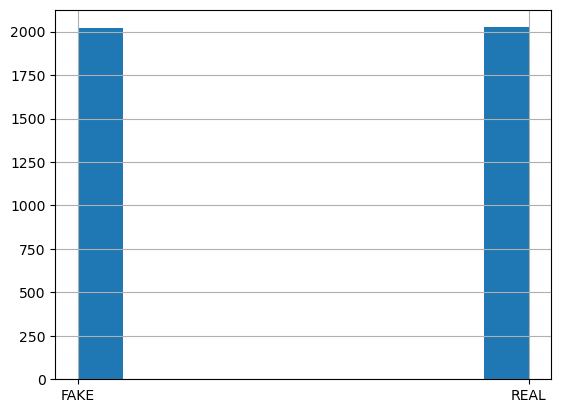

In [185]:
train_data['label'].hist()

<Axes: >

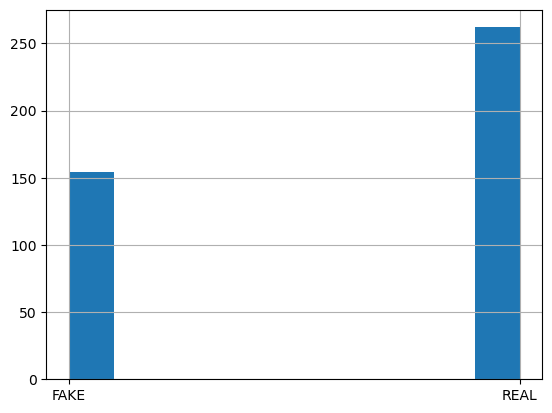

In [186]:
test_data['label'].hist()

In [187]:
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 4044
Test set size: 416


In [188]:
train_data.to_csv("train_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [189]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [190]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 2019
Label: REAL, Count: 2025


In [191]:
from torchvision import transforms


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str, image_size=(224, 224), transform=None):

        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.image_size = image_size
        
        self.transform = transform
        
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

    def __getitem__(self, n):
        video, metadata = self.videos[n]
        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Загальна кількість кадрів у відео
        start_frame = random.randint(0, max(0, total_frames - self.n_frames))  # Випадковий стартовий кадр

        # Перемотка до стартового кадру
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        frames = []

        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize = (self.image_size[0], self.image_size[1])
            frame = cv2.resize(frame, resize)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        frames = torch.stack(frames).to(self.device)
        
        if self.transform:
            frames = self.transform(frames)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)


    def __len__(self):
        return len(self.videos)

    
class SameAugmentation:
    def __init__(self, augmentations):
        """
        Args:
            augmentations (callable): Трансформації, що застосовуються до всіх кадрів.
        """
        self.augmentations = augmentations

    def __call__(self, frames):
        # Ініціалізуємо однакове перетворення
        seed = torch.randint(0, 2**32, (1,)).item()

        # Застосовуємо однакові трансформації до всіх кадрів
        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)  # Встановлюємо однаковий seed
            augmented_frames.append(self.augmentations(frame))
        
        return torch.stack(augmented_frames)

Label: tensor([1.], device='cuda:0')


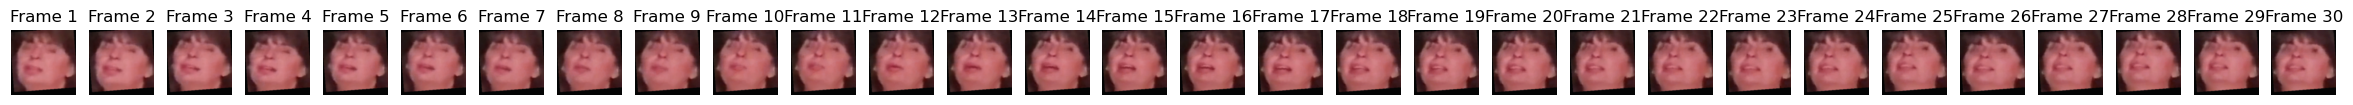

In [192]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transfor = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
        ])
    )
    
    dataset = VideoDataset(30, 'output_balenced_train.json', device, 'cache', (224, 224), transfor)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([30, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 30, figsize=(30, 10))

        for j in range(30):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([1.], device='cuda:0')


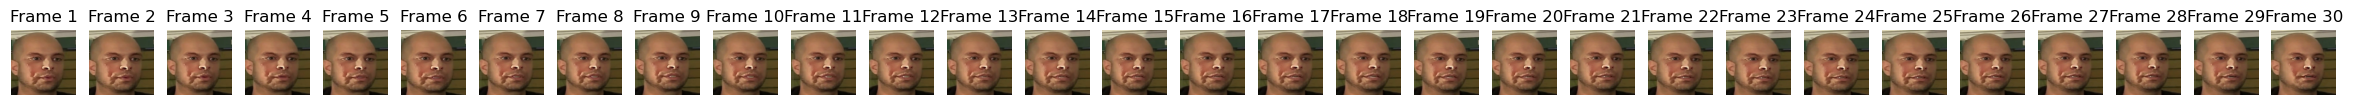

In [193]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(30, 'output_balenced_test.json', device, 'cache', (224, 224), None)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([30, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 30, figsize=(30, 10))

        for j in range(30):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [194]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout,
                 ):
        super(CNNLSTMClassifier, self).__init__()

        self.cnn = models.efficientnet_b5(pretrained=True)
        
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

        self.feature_output_size = 2048
        
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=0.1,
                            batch_first=True,
                            bidirectional=True)
        
        self.attention = nn.MultiheadAttention(embed_dim=lstm_hidden_dim * (2 if bidirectional else 1),
                                               num_heads=num_heads,
                                               dropout=0.1,
                                               batch_first=True)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)

        # Переформатовуємо ознаки для LSTM
        vid_features = vid_features.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        # Механізм multihead уваги
        # Отримуємо вихід уваги та ваги
        attention_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Агрегуємо ваги уваги по всіх "головах"
        attention_weights = attention_weights.mean(dim=1)  # Середнє по num_heads, розмір (batch_size, num_frames)

        # Використовуємо ваги для вагового середнього
        weighted_out = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)  # Розмір (batch_size, lstm_hidden_dim)

        # Класифікація з дропаути
        x = torch.relu(self.fc1(weighted_out))
        x = self.dropout1(x)  # Додаємо дропаути після активації
        x = self.fc2(x)
        
        return x

In [195]:
class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()

        
class ResNetLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout,
                 bidirectional,
                 ):
        super(ResNetLSTMClassifier, self).__init__()

        # Завантажуємо попередньо натреновану модель ResNeXt50
        self.cnn = MyResNeXt('/home/ec2-user/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth')
        
        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048
        
        # Заморожуємо шари до певного рівня
        self.freeze_until("layer4.0.conv1.weight")

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],  # Використовуємо всі шари до передостаннього
            nn.AdaptiveMaxPool2d((1, 1))  # Адаптивне середнє значення
        )

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        # Додаємо LayerNorm до LSTM виходу
        self.lstm_norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))

        # Повнозв'язні шари для класифікації
        if bidirectional:
            self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        else:
            self.fc1 = nn.Linear(lstm_hidden_dim, n_linear_hidden)

        # Додаємо дропаути для кожного з класів
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)
        self.dropout2 = nn.Dropout(dropout)

    def freeze_until(self, param_name):
        """Заморожує всі шари до `param_name`, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо ResNeXt як фічерний екстрактор
        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка LSTM
        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        # Нормалізація LSTM виходу
        lstm_out = torch.mean(lstm_out, dim=1) # Середнє по num_heads, розмір (batch_size, num_frames)
        
        lstm_out = self.lstm_norm(lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Класифікація з дропаути
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout1(x)  # Додаємо дропаути після активації
        x = self.fc2(x)

        return x

In [196]:
import torch
import torch.nn as nn
from torchvision import models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, lstm_output):
        energy = self.projection(lstm_output)
        weights = torch.softmax(energy.squeeze(-1), dim=1)
        attended_output = (lstm_output * weights.unsqueeze(-1)).sum(dim=1)
        return attended_output

class LSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.cnn = MyResNeXt('/home/ec2-user/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth')
        self.feature_output_size = 2048
        self.freeze_until("layer4.0.conv1.weight")
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-2],
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)
        self.attention = SelfAttention(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)
        self.fc2 = nn.Linear(n_linear_hidden, 1)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(40)

    def freeze_until(self, param_name):
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)
        features = self.cnn(vid_frames)
        features = features.view(batch_size, num_frames, -1)
        lstm_out, _ = self.lstm(features)
        lstm_out = self.bn(lstm_out)
        attended_output = self.attention(lstm_out)
        x = torch.relu(self.fc1(attended_output))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [197]:
import torch
import torch.nn as nn
import torchvision.models as models


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
    
class EfficientNetB1LSTM(nn.Module):
    """
    Implementation of a EfficientNetB1 + LSTM that was one part of the DeepfakeDetection Challenge
    Rank 90 private leaderboard solution https://www.kaggle.com/c/deepfake-detection-challenge/leaderboard 

    # Architecture inspired by https://www.kaggle.com/unkownhihi/dfdc-lrcn-inference
    
    To make it comparable with ResNet50 + LSTM it uses the same fully connected layers and 
    also uses 512 hidden units as it was described in the paper
    DeeperForensics-1.0: A Large-Scale Dataset for Real-World Face Forgery Detection (https://arxiv.org/abs/2001.03024)

    # parts from https://discuss.pytorch.org/t/solved-concatenate-time-distributed-cnn-with-lstm/15435/2
    # and from https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/6 

    # adapted by: Christopher Otto

    Arguments:
        hidden_size = 512  # as described in the Deeperforensics-1.0 paper
    """
    def __init__(self, input_size=128, hidden_size=512, num_layers=2, num_classes=1):
        super(EfficientNetB1LSTM, self).__init__()
        self.b1 = models.efficientnet_b1(pretrained=True)
        # delete b1 fc layer
        self.b1 = nn.Sequential(*list(self.b1.children())[:-2],
                   nn.Conv2d(1280, 128, 1, bias=False),
                   nn.BatchNorm2d(128),
                   Swish(),
                   nn.AdaptiveAvgPool2d((1, 1)))
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        # another fc layer, because it seems to improve performance
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # [32, 20, 3, 224, 224]
        batch_size, num_frames, channels, height, width = x.size()
        # combine batch and frame dimensions for 2d cnn
        c_in = x.reshape(batch_size * num_frames, channels, height, width)
        c_out = self.b1(c_in)
        # separate batch and frame dimensions for lstm 
        c_out = c_out.view(batch_size, num_frames, -1)
        r_out, _ = self.lstm(c_out)
        # get last hidden state
        out = self.relu(self.fc1(r_out[:, -1, :]))
        result = self.fc2(out)
        return result

In [198]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    minposs = val_losses.index(min(val_losses)) 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [199]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [200]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

class LSTM_attention_with_CNN(nn.Module):
    def __init__(self, hidden_dim=256, layer_dim=1, output_dim=1, 
                 bi_dir=True, n_head=4, dropout=0.1, seed=100, device='cuda'):
        super(LSTM_attention_with_CNN, self).__init__()
        torch.manual_seed(seed)
        self.device = device
        self.bi_dir_c = 2 if bi_dir else 1
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.kdim = hidden_dim * self.bi_dir_c
        self.vdim = hidden_dim * self.bi_dir_c

        # CNN feature extractor
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        
        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048
        
        # Заморожуємо шари до певного рівня
        self.freeze_until('layer4.0.conv1.weight')

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],  # Використовуємо всі шари до передостаннього
            nn.AdaptiveAvgPool2d((1, 1))  # Адаптивне середнє значення
        )

        # LSTM model
        self.lstm = nn.LSTM(self.feature_output_size, hidden_dim, layer_dim, batch_first=True, bidirectional=bi_dir)

        # Multihead attention
        self.q = nn.Linear(hidden_dim * self.bi_dir_c, self.kdim)
        self.k = nn.Linear(hidden_dim * self.bi_dir_c, self.kdim)
        self.v = nn.Linear(hidden_dim * self.bi_dir_c, self.vdim)
        
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=self.bi_dir_c * hidden_dim, 
            num_heads=n_head, 
            dropout=dropout, 
            kdim=self.kdim, 
            vdim=self.vdim, 
            batch_first=True
        )
        
        self.norm = nn.LayerNorm([30, hidden_dim * self.bi_dir_c])  # Adjust size based on sequence length

        # Fully connected layer
        self.fc = nn.Linear(self.vdim, output_dim)

    def attention(self, lstm_hidden_layer):
        query = self.q(lstm_hidden_layer)
        key = self.k(lstm_hidden_layer)
        value = self.v(lstm_hidden_layer)
        attention_out, weights = self.multihead_attention(query, key, value)
        return attention_out
    
    def freeze_until(self, param_name):
        """Заморожує всі шари до `param_name`, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, x):
        # x: (batch_size, seq_len, channels, height, width)
        batch_size, seq_len, channels, height, width = x.size()

        # Flatten batch and sequence dimensions for CNN
        x = x.view(batch_size * seq_len, channels, height, width)
        cnn_features = self.feature_extractor(x)  # (batch_size * seq_len, cnn_output_dim)

        # Reshape back to sequence format
        cnn_features = cnn_features.view(batch_size, seq_len, -1)  # (batch_size, seq_len, lstm_input_dim)

        # Initialize LSTM hidden states
        h0 = torch.zeros(self.layer_dim * self.bi_dir_c, batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.layer_dim * self.bi_dir_c, batch_size, self.hidden_dim).to(self.device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(cnn_features, (h0, c0))  # (batch_size, seq_len, hidden_dim * bi_dir_c)

        # Attention mechanism
        attention_out = self.attention(lstm_out)
        norm_out = self.norm(attention_out + lstm_out)
        norm_out = torch.mean(norm_out, dim=1)
        # Fully connected output
        out = self.fc(norm_out)  # (batch_size, seq_len, output_dim)
        return out

In [201]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True)
        self.inception_v3.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        # Extract the primary output from InceptionV3
        x = self.inception_v3(x)
        if isinstance(x, torch.Tensor):
            return x
        else:
            # If the output is an InceptionOutputs object, extract the primary output
            return x.logits
    
    
class VideoClassifier(nn.Module):
    def __init__(self):
        super(VideoClassifier, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.lstm = nn.LSTM(input_size=2048, hidden_size=128, batch_first=True, bidirectional=False)
        self.gru = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        x = x.view(batch_size * seq_len, channels, height, width)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take the last time step's output
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [202]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import torch.nn.functional as F


class DynamicVideoClassifier(nn.Module):
    def __init__(self, backbone='resnet50', hidden_size=512, num_layers=2, dropout=0.2):
        super().__init__()

        # List of valid backbones
        self.valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2', 'inception_v3'
        ]
        
        # Ensure the provided backbone is valid
        if backbone not in self.valid_backbones:
            raise ValueError(f"Invalid backbone. Choose from {', '.join(self.valid_backbones)}")

        # Load the CNN backbone and get feature size
        self.backbone = getattr(models, backbone)(pretrained=True)
        avg_size = 1
        # print(self.backbone)
        # Adjust feature size based on the model architecture
        
        if backbone in ['resnet18', 'resnet50']:
            self.feature_size = self.backbone.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove fully connected layer
        elif backbone == 'vgg16':
            self.feature_size = self.backbone.classifier[0].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1][0])  # Remove classifier
            avg_size = 7
        elif backbone == 'densenet121':
            self.feature_size = self.backbone.classifier.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'mobilenet_v2':
            self.feature_size = self.backbone.classifier[1].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'inception_v3':
            self.feature_size = self.backbone.AuxLogits.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier

        self.freeze_until('layer4.0.conv1.weight')
        
        self.avg_pool = nn.AdaptiveAvgPool2d((avg_size, avg_size))  # Applies average pooling over spatial dimensions (H, W)
        # LSTM for temporal features
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Attention mechanism
        #self.attention = nn.Sequential(
        #    nn.Linear(hidden_size, hidden_size),
        #    nn.Tanh(),
        #    nn.Linear(hidden_size, 1)
        #)
        self.attention = nn.MultiheadAttention(hidden_size,2, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
        )

    def freeze_until(self, param_name):
        found_name = False
        for name, params in self.backbone.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name
    
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()

        
        # CNN feature extraction
        x = x.view(-1, c, h, w)
        # print('Input X: ',x.shape)
        x = self.backbone(x)
        x = self.avg_pool(x)
        # print('Output from CNN X: ',x.shape)
        x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, feature_size)
        
        # LSTM processing
        # print('Input LSTM: ',x.shape)
        lstm_out, _ = self.lstm(x)
        # print('Output LSTM: ',lstm_out.shape)
        
        # Attention mechanism
        # print('Input Att: ',lstm_out.shape)
        #attention_weights = self.attention(lstm_out)
        #attention_weights = torch.softmax(attention_weights, dim=1)
        #attended_features = torch.sum(attention_weights * lstm_out, dim=1)
        # print('Output Att: ',attended_features.shape)
        attended_features, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        attended_features = self.layer_norm(lstm_out + attended_features)
        attended_features = torch.mean(attended_features, dim=1)  # Average across sequence
        # print('Output Att: ',attended_features.shape)
        # Classification
        output = self.classifier(attended_features)
        # print("Output: ",output.shape)
        # print("SE: ",output.squeeze().shape)
        return output


In [203]:
class ResNetLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout,
                 bidirectional,
                 num_heads=4  # Кількість голів для multihead attention
                 ):
        super(ResNetLSTMClassifier, self).__init__()

        # Завантажуємо попередньо натреновану модель ResNeXt50
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        
        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048
        
        # Заморожуємо шари до певного рівня
        self.freeze_until("layer4.0.conv1.weight")

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],  # Використовуємо всі шари до передостаннього
            nn.AdaptiveMaxPool2d((1, 1))  # Адаптивне середнє значення
        )

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=0.1,
                            batch_first=True,
                            bidirectional=bidirectional)

        # Механізм multihead уваги
        self.attention = nn.MultiheadAttention(embed_dim=lstm_hidden_dim * (2 if bidirectional else 1),
                                               num_heads=num_heads,
                                               dropout=0.1,
                                               batch_first=True)

        # Додаємо LayerNorm до LSTM виходу
        self.lstm_norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))

        # Повнозв'язні шари для класифікації
        if bidirectional:
            self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        else:
            self.fc1 = nn.Linear(lstm_hidden_dim, n_linear_hidden)

        # Додаємо дропаути для кожного з класів
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)
        self.dropout2 = nn.Dropout(dropout)

        # Додаємо LayerNorm до виходів перед останнім fully connected шаром
        self.fc1_norm = nn.LayerNorm(n_linear_hidden)

    def freeze_until(self, param_name):
        """Заморожує всі шари до `param_name`, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо ResNeXt як фічерний екстрактор
        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка LSTM
        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        # Нормалізація LSTM виходу
        lstm_out = self.lstm_norm(lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Механізм multihead уваги
        # Отримуємо вихід уваги та ваги
        attention_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Агрегуємо ваги уваги по всіх "головах"
        attention_weights = attention_weights.mean(dim=1)  # Середнє по num_heads, розмір (batch_size, num_frames)

        # Використовуємо ваги для вагового середнього
        weighted_out = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)  # Розмір (batch_size, lstm_hidden_dim)

        # Нормалізація перед подачею на FC
        weighted_out = self.fc1_norm(weighted_out)

        # Класифікація з дропаути
        x = torch.relu(self.fc1(weighted_out))
        x = self.dropout1(x)  # Додаємо дропаути після активації
        x = self.fc2(x)
        x = self.dropout2(x)  # Додаємо дропаути перед виходом

        return x

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=42):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


class ResNetTransformerClassifier(nn.Module):
    def __init__(self, n_linear_hidden, transformer_dim, num_transformer_layers, num_heads, dropout):
        super(ResNetTransformerClassifier, self).__init__()

        # Завантажуємо попередньо натреновану модель ResNeXt50
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],  # Використовуємо всі шари до передостаннього
            nn.AdaptiveMaxPool2d((1, 1)),  # Адаптивне середнє значення
            nn.Flatten(),
            nn.Dropout(0.4)
        )

        # Позиційне кодування для трансформера
        self.positional_encoding = PositionalEncoding(transformer_dim)

        # Трансформер для обробки послідовності
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=num_heads, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

        # Нормалізація виходу трансформера
        self.transformer_norm = nn.LayerNorm(transformer_dim)

        # Повнозв’язні шари для класифікації
        self.fc1 = nn.Linear(transformer_dim, n_linear_hidden)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Витягуємо ознаки з ResNeXt
        vid_features = self.feature_extractor(vid_frames)
        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Змінюємо розмірність для трансформера (num_frames, batch_size, feature_dim)
        vid_features = self.positional_encoding(vid_features)
        vid_features = vid_features.permute(1, 0, 2)  # Переміщуємо розмірності для трансформера

        # Обробка через трансформер
        transformer_out = self.transformer(vid_features)

        # Повернення до розміру (batch_size, feature_dim)
        transformer_out = transformer_out.mean(dim=0)  # Усереднюємо кадри по осі часу
        transformer_out = self.transformer_norm(transformer_out)

        # Класифікація
        x = torch.relu(self.fc1(transformer_out))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

In [205]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]  
        return self.dropout(x)

    
class ResNetTransformerClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden=512,
                 transformer_d_model=512,
                 num_transformer_layers=4,
                 num_heads=8,
                 dim_feedforward=2048,
                 dropout=0.2):
        super().__init__()

        # Завантаження попередньо натренованої ResNeXt
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        self.feature_output_size = 2048
        
        # Фічерний екстрактор
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.5)
        )

        # Проекція ознак для трансформера
        self.feature_projection = nn.Linear(self.feature_output_size, transformer_d_model)
        
        # Позиційне кодування
        self.positional_encoding = PositionalEncoding(transformer_d_model, dropout)
        
        # Трансформер
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=transformer_d_model,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            ),
            num_layers=num_transformer_layers
        )

        # Класифікатор
        self.fc1 = nn.Linear(transformer_d_model, n_linear_hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, C, H, W = vid_frames.shape
        
        # Витягнення ознак
        features = self.feature_extractor(
            vid_frames.view(batch_size*num_frames, C, H, W)
        ).view(batch_size, num_frames, -1)
        
        # Проекція ознак
        projected = self.feature_projection(features)
        
        # Позиційне кодування
        projected = self.positional_encoding(projected)
        
        # Обробка трансформером
        transformer_out = self.transformer_encoder(projected)
        
        # Агрегація (середнє значення)
        aggregated = torch.mean(transformer_out, dim=1)
        
        # Класифікація
        x = F.relu(self.fc1(aggregated))
        x = self.dropout(x)
        return self.fc2(x)

In [206]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()

        
class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        
        attended_values = torch.bmm(attention_weights, value)
        return attended_values

    
class SelfAttentionAggregation(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttentionAggregation, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1)

    def forward(self, attention_output):
        # attention_output: (batch_size, seq_length, hidden_dim)
        weights = torch.softmax(self.attention_weights(attention_output), dim=1)  # (batch_size, seq_length, 1)
        video_representation = torch.sum(weights * attention_output, dim=1)  # (batch_size, hidden_dim)
        return video_representation

    
class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim,
                 num_lstm_layers, dropout, bidirectional):
        super(ResNetLSTMClassifier, self).__init__()
        
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        self.feature_output_size = 2048
        
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-2],
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Dropout(0.3)
        )
        
        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        self.self_attention = SelfAttention(lstm_hidden_dim * (2 if bidirectional else 1))
        
        self.lstm_norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))
        
        self.attention_aggregation = SelfAttentionAggregation(lstm_hidden_dim * (2 if bidirectional else 1))
        
        fc_input_dim = lstm_hidden_dim * (2 if bidirectional else 1)
        
        self.fc1 = nn.Linear(fc_input_dim, n_linear_hidden)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)
        
        vid_features = self.feature_extractor(vid_frames)
        vid_features = vid_features.view(batch_size, num_frames, -1)
        
        lstm_out, _ = self.lstm(vid_features)
        
        attention_out = self.self_attention(lstm_out)
        
        residual = self.lstm_norm(lstm_out + attention_out)
        
        x = self.attention_aggregation(residual)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [207]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, size: tuple[int], device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)
    
    early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.0001, path=f'experiments/early_stopping_{name}_lstm_checkpoint.pt')

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    transfor_train = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
            # Нормалізація
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    )
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache', size, transfor_train)
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache', size, transfor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()
        torch.cuda.empty_cache()
        gc.collect()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()
            gc.collect()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        torch.cuda.empty_cache()
        gc.collect()
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())

                loss = criterion(output, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

                torch.cuda.empty_cache()
                gc.collect()
        
        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')
        
        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'experiments/best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
        )
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Validation AUC: {val_auc}')

In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()

        
class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)  # Dropout у самоувазі

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights)  # Додаємо Dropout

        attended_values = torch.bmm(attention_weights, value)
        return attended_values

    
class ResNetLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout,
                 bidirectional,
                 ):
        super(ResNetLSTMClassifier, self).__init__()

        # Завантажуємо попередньо натреновану модель ResNeXt50
        self.cnn = MyResNeXt('/home/ec2-user/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth')

        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048

        # Заморожуємо шари до певного рівня
        #self.freeze_until("layer4.0.conv1.weight")

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
            nn.Dropout(0.4)
        )

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=0.1,
                            batch_first=True,
                            bidirectional=bidirectional)

        # Додаємо LayerNorm до LSTM виходу
        self.lstm_norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))

        # Шар самоуваги
        self.attention = SelfAttention(lstm_hidden_dim * (2 if bidirectional else 1))

        # Повнозв'язні шари для класифікації
        if bidirectional:
            self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        else:
            self.fc1 = nn.Linear(lstm_hidden_dim, n_linear_hidden)

        # Додаємо дропаути для кожного з класів
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def freeze_until(self, param_name):
        """Заморожує всі шари до param_name, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо ResNeXt як фічерний екстрактор
        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка LSTM
        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        # Нормалізація LSTM виходу
        lstm_out = self.lstm_norm(lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Додаємо механізм самоуваги
        attended_out = self.attention(lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)

        # Утворення фінального представлення
        attended_out = torch.mean(attended_out, dim=1)  # Середнє по num_frames, розмір (batch_size, lstm_hidden_dim)

        # Класифікація з дропаути
        x = torch.relu(self.fc1(attended_out))
        x = self.dropout1(x)  # Додаємо дропаути після активації
        x = self.fc2(x)

        return x

In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        
        self.fc = nn.Identity()


class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights) 

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        
        attention_weight:
            att_w : size (N, T, 1)
        
        return:
            utter_rep: size (N, H)
        """
        softmax = nn.functional.softmax
        att_w = softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep

    
class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, 
                 num_lstm_layers, dropout, bidirectional, freeze):
        super(ResNetLSTMClassifier, self).__init__()

        # ResNeXt50 як фічерний екстрактор
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

        self.feature_output_size = 128

        if freeze:
            self.freeze_until("layer4.0.conv1.weight")

        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-2],
            nn.Conv2d(2048, 128, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # LSTM для обробки послідовності
        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
    
        self.lstm_norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))

        self.fc1 = nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), n_linear_hidden)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def freeze_until(self, param_name):
        """Заморожує всі шари до param_name, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            params.requires_grad = False
            if name == param_name:
                found_name = True
                break

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # CNN Feature Extraction
        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)
        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # LSTM обробка послідовності
        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)
        lstm_out = self.lstm_norm(lstm_out)  # (batch_size, num_frames, lstm_hidden_dim)
        
        # Класифікація
        x = F.relu(self.fc1(lstm_out[:, -1, :]))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()

        
class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights) 

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers, 
                 dropout, bidirectional, freeze):
        super(ResNetLSTMClassifier, self).__init__()
        
        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        self.feature_output_size = 256
        
        if freeze:
            self.freeze_until("layer4.0.conv1.weight")
        
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-2],
            nn.Conv2d(2048, 256, 1, bias=False),
            nn.BatchNorm2d(256),
            Swish(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        self.attention = SelfAttention(lstm_hidden_dim * (2 if bidirectional else 1))

        self.norm = nn.LayerNorm(lstm_hidden_dim * (2 if bidirectional else 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, 1),
        )

        self.target_layer = self.feature_extractor[-4]
        self.activations = None
        self.gradients = None
        self.target_layer.register_forward_hook(self.save_activations_hook())
        self.target_layer.register_backward_hook(self.save_gradients_hook())

    def save_activations_hook(self):
        def hook(module, input, output):
            self.activations = output
        return hook

    def save_gradients_hook(self):
        def hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        return hook

    def freeze_until(self, param_name):
        found = False
        for name, param in self.cnn.named_parameters():
            if name == param_name:
                found = True
            param.requires_grad = found

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        attended_out = self.attention(lstm_out)
        attended_out =  self.norm(attended_out + lstm_out)
        attended_out = torch.mean(attended_out, dim=1)

        output = self.classifier(attended_out)
        
        return output

Training ResNetLSTMClassifier20x224 model:
Hyperparameters {'n_linear_hidden': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 2, 'dropout': 0.4, 'bidirectional': True, 'freeze': False, 'n_frames': 20, 'batch_size': 8, 'lr': 1e-05, 'num_epochs': 25, 'gamma': 0.1, 'milestones': [32, 64]}
Start time: 2025-02-04 08:34:10.769651, using device: cuda


Epoch 1/25 - Train loss: 0.6506, Train accuracy: 0.6192
Validation loss: 0.6282, Validation accuracy: 0.6731, Time: 845.05s
Validation loss decreased (inf --> 0.628185).  Saving model ...


Epoch 2/25 - Train loss: 0.5507, Train accuracy: 0.7428
Validation loss: 0.5364, Validation accuracy: 0.7500, Time: 843.44s
Validation loss decreased (0.628185 --> 0.536383).  Saving model ...


Epoch 4/25 - Train loss: 0.4189, Train accuracy: 0.8304
Validation loss: 0.4871, Validation accuracy: 0.7596, Time: 843.35s
Validation loss decreased (0.491183 --> 0.487061).  Saving model ...


Epoch 5/25 - Train loss: 0.3666, Train accuracy: 0.8586
Validation loss: 0.5393, Validation accuracy: 0.7692, Time: 842.80s
EarlyStopping counter: 1 out of 15


Epoch 6/25 - Train loss: 0.3662, Train accuracy: 0.8544
Validation loss: 0.4442, Validation accuracy: 0.8053, Time: 843.53s
Validation loss decreased (0.487061 --> 0.444211).  Saving model ...


Epoch 7/25 - Train loss: 0.3382, Train accuracy: 0.8635
Validation loss: 0.4878, Validation accuracy: 0.7837, Time: 843.74s
EarlyStopping counter: 1 out of 15


Epoch 8/25 - Train loss: 0.2911, Train accuracy: 0.8907
Validation loss: 0.3782, Validation accuracy: 0.8510, Time: 842.12s
Validation loss decreased (0.444211 --> 0.378214).  Saving model ...


Epoch 9/25 - Train loss: 0.2923, Train accuracy: 0.8870
Validation loss: 0.4520, Validation accuracy: 0.7981, Time: 842.18s
EarlyStopping counter: 1 out of 15


Epoch 10/25 - Train loss: 0.2643, Train accuracy: 0.9078
Validation loss: 0.3923, Validation accuracy: 0.8245, Time: 842.10s
EarlyStopping counter: 2 out of 15


Epoch 11/25 - Train loss: 0.2519, Train accuracy: 0.9060
Validation loss: 0.5303, Validation accuracy: 0.7596, Time: 842.55s
EarlyStopping counter: 3 out of 15


Epoch 12/25 - Train loss: 0.2502, Train accuracy: 0.9107
Validation loss: 0.4958, Validation accuracy: 0.7957, Time: 843.24s
EarlyStopping counter: 4 out of 15


Epoch 13/25 - Train loss: 0.2406, Train accuracy: 0.9127
Validation loss: 0.4214, Validation accuracy: 0.8341, Time: 844.24s
EarlyStopping counter: 5 out of 15


Epoch 14/25 - Train loss: 0.2184, Train accuracy: 0.9177
Validation loss: 0.5708, Validation accuracy: 0.7764, Time: 842.00s
EarlyStopping counter: 6 out of 15


Epoch 15/25 - Train loss: 0.2139, Train accuracy: 0.9256
Validation loss: 0.3448, Validation accuracy: 0.8654, Time: 842.90s
Validation loss decreased (0.378214 --> 0.344771).  Saving model ...


Epoch 16/25 - Train loss: 0.1967, Train accuracy: 0.9310
Validation loss: 0.4438, Validation accuracy: 0.8197, Time: 843.03s
EarlyStopping counter: 1 out of 15


Epoch 17/25 - Train loss: 0.1915, Train accuracy: 0.9318
Validation loss: 0.5391, Validation accuracy: 0.7957, Time: 842.01s
EarlyStopping counter: 2 out of 15


Epoch 18/25 - Train loss: 0.1860, Train accuracy: 0.9322
Validation loss: 0.6542, Validation accuracy: 0.7716, Time: 841.84s
EarlyStopping counter: 3 out of 15


Epoch 19/25 - Train loss: 0.1648, Train accuracy: 0.9424
Validation loss: 0.5932, Validation accuracy: 0.7548, Time: 842.57s
EarlyStopping counter: 4 out of 15


Epoch 20/25 - Train loss: 0.1775, Train accuracy: 0.9350
Validation loss: 0.5285, Validation accuracy: 0.7716, Time: 842.75s
EarlyStopping counter: 5 out of 15


Epoch 21/25 - Train loss: 0.1705, Train accuracy: 0.9399
Validation loss: 0.4402, Validation accuracy: 0.8293, Time: 843.64s
EarlyStopping counter: 6 out of 15


Epoch 22/25 - Train loss: 0.1495, Train accuracy: 0.9463
Validation loss: 0.3733, Validation accuracy: 0.8510, Time: 842.66s
EarlyStopping counter: 7 out of 15


Epoch 23/25 - Train loss: 0.1438, Train accuracy: 0.9481
Validation loss: 0.4942, Validation accuracy: 0.8173, Time: 842.45s
EarlyStopping counter: 8 out of 15


Epoch 24/25 - Train loss: 0.1538, Train accuracy: 0.9478
Validation loss: 0.4338, Validation accuracy: 0.8365, Time: 843.19s
EarlyStopping counter: 9 out of 15


Epoch 25/25 - Train loss: 0.1519, Train accuracy: 0.9483
Validation loss: 0.4532, Validation accuracy: 0.8269, Time: 842.89s
EarlyStopping counter: 10 out of 15
Training completed in: 5:51:25.900618


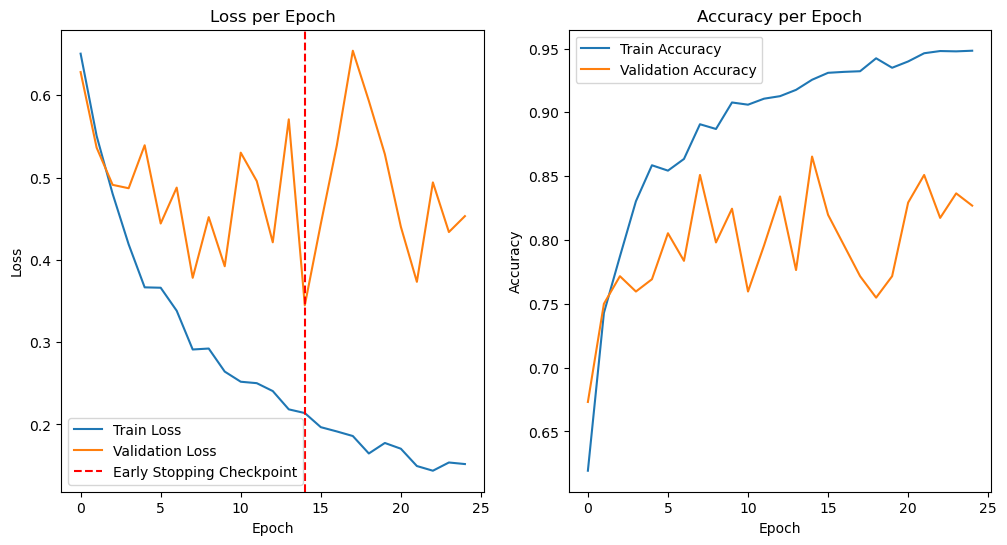

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95      2025
         1.0       0.94      0.95      0.95      2019

    accuracy                           0.95      4044
   macro avg       0.95      0.95      0.95      4044
weighted avg       0.95      0.95      0.95      4044



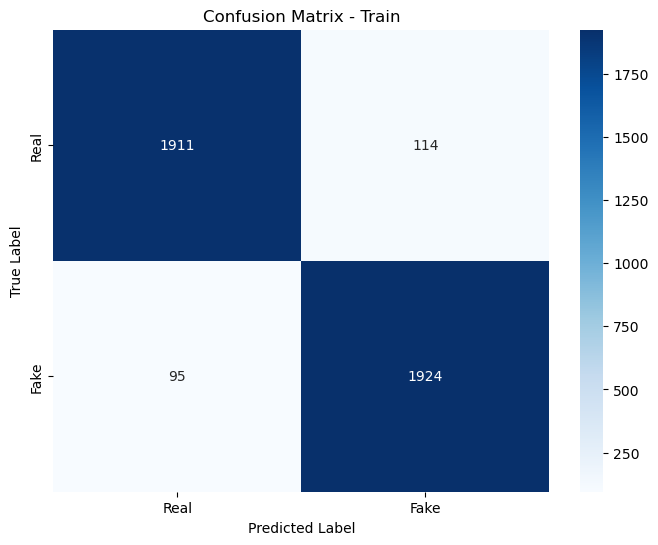

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.85       262
         1.0       0.70      0.94      0.80       154

    accuracy                           0.83       416
   macro avg       0.83      0.85      0.82       416
weighted avg       0.86      0.83      0.83       416



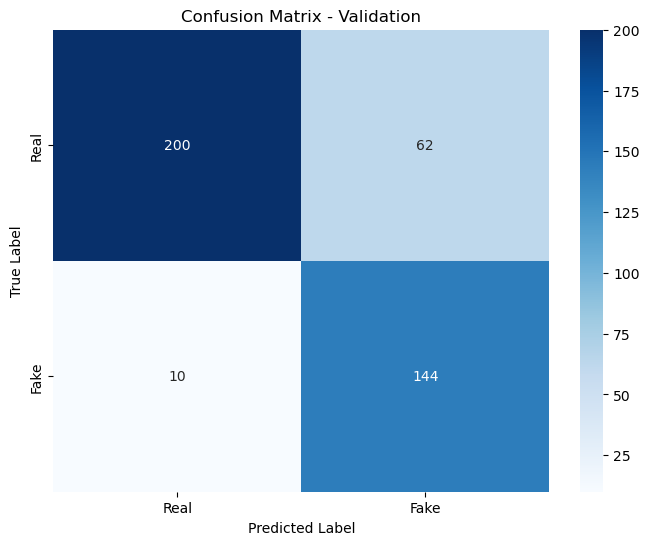

Validation AUC: 0.9301576286309111


In [ ]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 128,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': True,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 8,
    'lr': 0.00001,
    'num_epochs': 25,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [(ResNetLSTMClassifier, 'ResNetLSTMClassifier20x224', (224, 224), hyperparameters_1)]


for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        n_linear_hidden=hyperparameters['n_linear_hidden'],
        lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
        num_lstm_layers=hyperparameters['num_lstm_layers'],
        dropout=hyperparameters['dropout'],
        bidirectional=hyperparameters['bidirectional'],
        freeze=hyperparameters['freeze']
    )

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_test.json', size, device, name)
    del model

In [ ]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 128,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': True,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 8,
    'lr': 0.00001,
    'num_epochs': 30,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [(ResNetLSTMClassifier, 'ResNetLSTMClassifier20x224', (224, 224), hyperparameters_1)]


for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        n_linear_hidden=hyperparameters['n_linear_hidden'],
        lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
        num_lstm_layers=hyperparameters['num_lstm_layers'],
        dropout=hyperparameters['dropout'],
        bidirectional=hyperparameters['bidirectional'],
        freeze=hyperparameters['freeze']
    )

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_test.json', size, device, name, 'experiments/best_ResNetLSTMClassifier20x224_lstm_checkpoint_epoch_25.pt')
    del model

Training ResNetLSTMClassifier20x224 model:
Hyperparameters {'n_linear_hidden': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 2, 'dropout': 0.4, 'bidirectional': True, 'freeze': False, 'n_frames': 20, 'batch_size': 8, 'lr': 1e-05, 'num_epochs': 30, 'gamma': 0.1, 'milestones': [32, 64]}
Start time: 2025-02-04 19:56:28.379126, using device: cuda


Epoch 26/30 Training:   1%|▏         | 7/506 [00:11<13:42,  1.65s/it]

In [211]:
def test_model(model: nn.Module, data_path: str, n_frames: int, size: Tuple[int, int]):
    batch_size = 8
    epoch_v_loss = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    test_dataset = VideoDataset(n_frames, data_path, device, 'cache', size, transfor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    torch.cuda.empty_cache()
    gc.collect()
    
    all_val_labels, all_val_preds = [], []
    test_probs = []
    with torch.no_grad():
        for video_data, labels in tqdm(test_loader, desc="Test", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            output = model(video_data)
            output_probs = torch.sigmoid(output)
            test_probs.extend(output_probs.cpu().numpy())

            loss = criterion(output, labels)
            epoch_v_loss += loss.item()

            output = torch.sigmoid(output).round()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(output.cpu().numpy())

            torch.cuda.empty_cache()
            gc.collect()
        
    val_loss = epoch_v_loss / len(test_loader)
    val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)

    print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_accuracy:.4f}')

    print("Test Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Test')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Test AUC: {val_auc}')

Test loss: 0.3336, Test accuracy: 0.8870
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       262
         1.0       0.85      0.85      0.85       154

    accuracy                           0.89       416
   macro avg       0.88      0.88      0.88       416
weighted avg       0.89      0.89      0.89       416



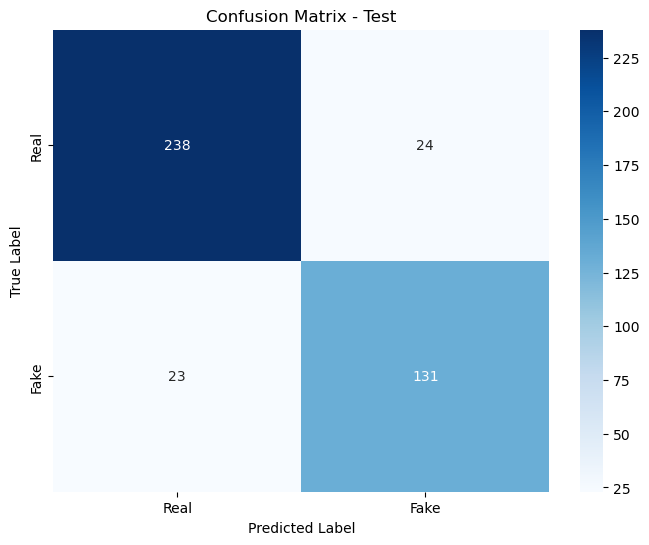

Test AUC: 0.9275057004064637


In [217]:
model_path = 'experiments/best_ResNetLSTMClassifier20x224_lstm_checkpoint_epoch_15.pt'

hyperparameters: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 128,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': True,
    'freeze': False,
    'n_frames': 20,
}
    
model = ResNetLSTMClassifier(
    n_linear_hidden=hyperparameters['n_linear_hidden'],
    lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
    num_lstm_layers=hyperparameters['num_lstm_layers'],
    dropout=hyperparameters['dropout'],
    bidirectional=hyperparameters['bidirectional'],
    freeze=hyperparameters['freeze']
)
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

test_model(model, 'output_balenced_test.json', 20, (224, 224))

In [218]:
def compute_grad_cam(model, input_video, target_class=None):
    """
    Обчислює Grad-CAM для заданого вхідного відео, залишаючи модель у режимі eval.
    Ми тимчасово відключаємо cuDNN, щоб backward для LSTM пройшов без помилок,
    хоча модель не навчається і ваги не оновлюються.

    Аргументи:
        model: Модель з зареєстрованими hooks.
        input_video: Тензор розміру [batch_size, num_frames, C, H, W].
        target_class: Індекс цільового класу (якщо None, використовується вихід першого нейрона).

    Повертає:
        cams: Список теплових карт для кожного кадру.
    """
    # Зберігаємо поточний стан cuDNN та вимикаємо його
    old_cudnn_enabled = torch.backends.cudnn.enabled
    torch.backends.cudnn.enabled = False

    # Модель залишається в eval() – це важливо, якщо Ви не хочете, щоб модель навчалась
    model.eval()
    
    batch_size, num_frames, C, H, W = input_video.shape
    output = model(input_video)
    
    if target_class is None:
        target = output[:, 0]
    else:
        target = output[target_class]
    
    model.zero_grad()
    # Обчислюємо backward для Grad-CAM; оскільки cuDNN вимкнено, backward LSTM працюватиме
    target.backward(torch.ones_like(target), retain_graph=True)
    
    activations = model.activations.detach()
    gradients = model.gradients.detach()
    
    cams = []
    # Проходимось по кожному прикладу в батчі
    for b in range(batch_size):
        batch_cams = []
        for t in range(num_frames):
            idx = b * num_frames + t
            act = activations[idx:idx+1]  # [1, channels, h, w]
            grad = gradients[idx:idx+1]     # [1, channels, h, w]
            
            alpha = grad.mean(dim=(2, 3), keepdim=True)
            cam = (alpha * act).sum(1, keepdim=True)
            cam = F.relu(cam)
            
            cam = cam.squeeze().cpu().numpy()
            cam = cv2.resize(cam, (W, H))
            cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
            batch_cams.append(cam)
        cams.append(batch_cams)
    
    # Повертаємо попереднє значення cuDNN
    torch.backends.cudnn.enabled = old_cudnn_enabled
    
    return cams


def overlay_heatmap(frame, heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(frame, 0.5, heatmap, 0.5, 0)
    return overlayed


def save_checkpoint(model, optimizer, filename):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)
    print(f"Checkpoint збережено у {filename}")

    
def load_checkpoint(model, optimizer, filename, device='cpu'):
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Checkpoint завантажено з {filename}")

Sequence 1: 20 frames
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


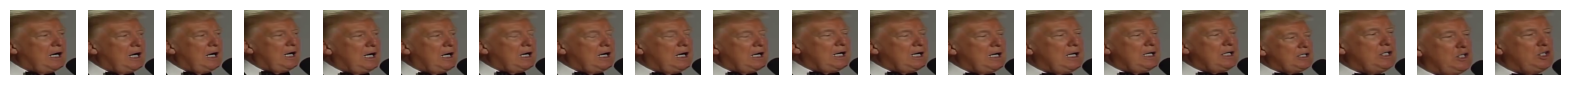

Sequence 2: 20 frames
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


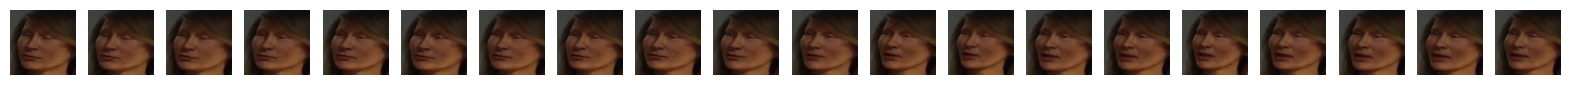

In [221]:
def process_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    detector = MTCNN(device='cuda', post_process=False)
    boxes, _ = detector.detect(frame, landmarks=False)

    if boxes is None:
        return None

    faces = []
    for box in boxes:
        width = box[2] - box[0]
        height = box[3] - box[1]
        expand_x = width * 0.3 / 2
        expand_y = height * 0.3 / 2
        x1 = max(int(box[0] - expand_x), 0)
        y1 = max(int(box[1] - expand_y), 0)
        x2 = min(int(box[2] + expand_x), frame.shape[1])
        y2 = min(int(box[3] + expand_y), frame.shape[0])

        face = frame[y1:y2, x1:x2]
        face = cv2.resize(face, (224, 224))
        face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
        faces.append((face, box))

    return faces


def extract_frames(video_path, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    face_sequences = {}
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        processed_faces = process_frame(frame)
        if processed_faces is not None:
            for face, box in processed_faces:
                is_unique = True
                for key, (prev_box, _) in face_sequences.items():
                    if abs(box[0] - prev_box[0]) < 50 and abs(box[1] - prev_box[1]) < 50 and \
                       abs(box[2] - prev_box[2]) < 50 and abs(box[3] - prev_box[3]) < 50:
                        is_unique = False
                        face_sequences[key][1].append(face)
                        break
                if is_unique:
                    face_sequences[len(face_sequences)] = (box, [face])

    cap.release()

    min_length = min(len(seq) for _, seq in face_sequences.values())
    face_sequences = {key: seq for key, (_, seq) in face_sequences.items()}

    return list(face_sequences.values())


video_path = "Melania Trump Deepfake with Vladimir Putin's Face.mp4"
face_sequences = extract_frames(video_path)

for i, seq in enumerate(face_sequences):
    print(f"Sequence {i+1}: {len(seq)} frames")
    for frame in seq:
        print(frame.shape)  # (3, 224, 224)
    seq = torch.stack([frame for frame in seq])

    seq = seq.unsqueeze(0)  # Shape: (1, num_frames, channels, height, width)

    fig, axes = plt.subplots(1, len(seq.squeeze(0)), figsize=(20, 5))
    for i, frame in enumerate(seq.squeeze(0)):  # Видаляємо зайвий вимір
        frame_np = frame.permute(1, 2, 0).numpy()
        axes[i].imshow(frame_np)
        axes[i].axis('off')
    plt.show()

Обрана послідовність містить 20 кадр(ів).
Класифікаційний вихід: [[0.8299746]]


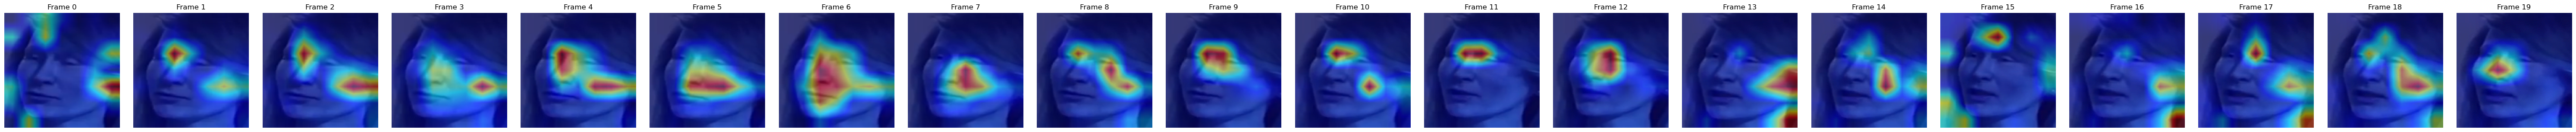

In [222]:
sequence = face_sequences[1]
num_frames = len(sequence)
print(f"Обрана послідовність містить {num_frames} кадр(ів).")

video_tensor = torch.stack(sequence, dim=0).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(video_tensor)
    print("Класифікаційний вихід:", output.cpu().numpy())
    
    # Обчислення Grad-CAM (буде виконано backward)
cams = compute_grad_cam(model, video_tensor)
    
    # Візуалізація кожного кадру з накладенням Grad-CAM
video_tensor_cpu = video_tensor.cpu().squeeze(0)  # [num_frames, 3, 224, 224]
fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 3, 3))
    # Якщо кадр лише один, забезпечуємо, щоб axes був ітерабельним
if num_frames == 1:
    axes = [axes]
    
for idx in range(num_frames):
        # Перетворення кадру: (3, 224, 224) -> (224, 224, 3)
    frame_tensor = video_tensor_cpu[idx]
    frame_np = frame_tensor.permute(1, 2, 0).numpy()
        # Нормалізація до [0, 255]
    frame_np = (frame_np - frame_np.min()) / (frame_np.max() - frame_np.min() + 1e-8)
    frame_np = np.uint8(frame_np * 255)
        
        # Отримання відповідної Grad-CAM теплової карти
    heatmap = cams[0][idx]
    overlayed = overlay_heatmap(frame_np, heatmap)
        
        # Відображення кадру на відповідній підграфіці
    axes[idx].imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Frame {idx}")
    axes[idx].axis("off")
    
plt.tight_layout()
plt.show()

In [ ]:
import torchvision.models.video as models_video


class ResNet3DClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet3DClassifier, self).__init__()
        self.cnn3d = models_video.r3d_18(weights="DEFAULT")
        self.cnn3d.stem[0] = nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):  # x: (batch, channels, time, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        features = self.cnn3d(x)
        features = torch.mean(features, dim=[2, 3, 4])  # Global Average Pooling
        output = self.classifier(features)
        return output


In [ ]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_frames': 32,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 15,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [(ResNet3DClassifier, 'ResNet3DClassifier', (224, 224), hyperparameters_1)]


for model_type, name, size, hyperparameters in models_to_train:
    model = model_type()

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_val.json', size, device, name)
    del model

In [ ]:
from transformers import VideoSwinModel


class VideoTransformerClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(VideoTransformerClassifier, self).__init__()
        self.video_swin = VideoSwinModel.from_pretrained("microsoft/video-swin-base")
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):  # x: (batch, channels, time, height, width)
        features = self.video_swin(x).last_hidden_state[:, 0, :]  # Беремо CLS-токен
        output = self.classifier(features)
        return output

In [ ]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_frames': 50,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 10,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [(VideoTransformerClassifier, 'VideoTransformerClassifier', (224, 224), hyperparameters_1)]


for model_type, name, size, hyperparameters in models_to_train:
    model = model_type()

    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_val.json', size, device, name)
    del model